In [98]:
%%capture
%run 1.1-ExploratoryDataAnalysis.ipynb

1. Importing libraries

In [99]:
import numpy as np

2. Creating a new feature from "PassengerId"

In [100]:
train_df["PassengerId"].head().to_frame()

,PassengerId
0,0001_01
1,0002_01
2,0003_01
3,0003_02
4,0004_01


### ❔ How will we do feature engineering on PassengerId
We know that each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number of people within the group. So we can create two new features, one will indicate total number of members present in each group, and the other indicating whether the passenger is travelling solo or in a group

In [101]:
def passengerid_new_features(df):
        # Splitting Group and Member values from "PassengerId" column
        df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
        df["Member"] = df["PassengerId"].apply(lambda x: x.split("_")[1])

        # Grouping the "Group" feature with "member" feature to check which group is travelling with how many members
        members_per_group = df.groupby("Group")["Member"].count()
        
        #Creating a set of group values which are travelling with more than 1 members
        more_than_one = members_per_group[members_per_group > 1]

        # Creating a new feature "Solo" which will indicate whether the person is travelling solo or not.
        df["Travelling Solo"] = df["Group"].apply(lambda y: y not in more_than_one)

        # Creating a new feature "Group_size" which will indicate each group number of members.
        df["Group Size"] = 0
        for i in members_per_group.items():
                df.loc[df["Group"] == i[0], "Group Size"] = i[1]

In [102]:
passengerid_new_features(train_df)
passengerid_new_features(test_df)

We don't require Group & Member features any more so we will drop those feature from both datasets

In [103]:
train_df.drop(columns = ["Group", "Member"], inplace = True)
test_df.drop(columns = ["Group", "Member"], inplace = True)

3. Visualizing "Group_Size" & "Travelling_Solo" Features

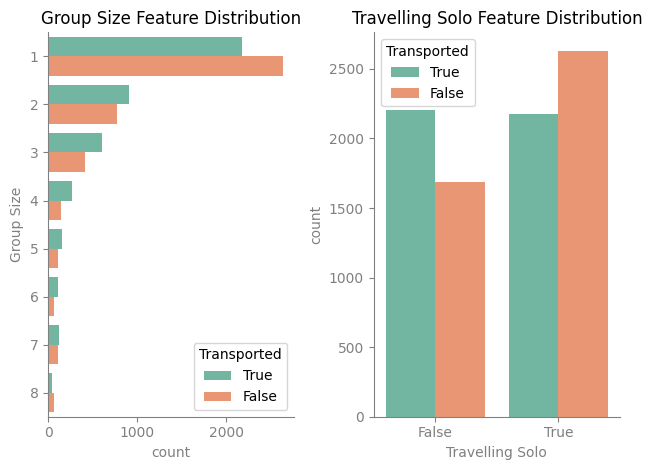

In [104]:
ax = plt.subplot(1, 2, 1)
sns.countplot(y = "Group Size", hue = "Transported", data = train_df, palette = "Set2", hue_order = order_transported)
plt.title("Group Size Feature Distribution")
plot_style(ax)
plt.tight_layout()
ax = plt.subplot(1, 2, 2)
sns.countplot(x = "Travelling Solo", hue = "Transported", data = train_df, palette = "Set2", hue_order = order_transported)
plt.title("Travelling Solo Feature Distribution")
plot_style(ax)
plt.tight_layout()

### ❕ Observations
From Group Size feature we can observe that most the passengers are travelling alone.
From Travelling Solo feature we can observe that passengers travelling solo are comparatively less transported when compared with passenger travelling in group.
Group sizes more than 1 are comparatively more transported when compared with passenger travelling solo

4. Creating new feature using "Cabin"

In [105]:
train_df["Cabin"].head().to_frame()

,Cabin
0,B/0/P
1,F/0/S
2,A/0/S
3,A/0/S
4,F/1/S


### ❔ How will we do feature engineering on Cabin
We know that cabin feature consists of deck/num/side, where deck is deck loacation, num is deck_number and side can be P for port or S for Starboard.
We can separate all these 3 values from cabin & create three new features: Cabin Deck, Cabin Number & Cabin Side.
We also know that Cabin feature is having NaN values so to avoid error while splitting we have to replace it in such a way taht we can split those NaN Values in all three new features respectively.

In [106]:
def cabin_new_features(df):
    # Split NaN values into all three categories
    df["Cabin"].fillna("np.nan/np.nan/np.nan", inplace = True)

    # Splitting Cabin Deck, Cabin Number & Cabin Side from "Cabin" column
    df["Cabin Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Cabin Number"] = df["Cabin"].apply(lambda x: x.split("/")[1])
    df["Cabin Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])

    # Replace string missing values to numpy nan values
    cols = ["Cabin Deck", "Cabin Number", "Cabin Side"]
    df[cols] = df[cols].replace("np.nan", np.nan) 

    # Filling Missing Values in new features created with the value that appears more often and median
    df["Cabin Deck"].fillna(df["Cabin Deck"].mode()[0], inplace = True)
    df["Cabin Side"].fillna(df["Cabin Side"].mode()[0], inplace = True)
    df["Cabin Number"].fillna(df["Cabin Number"].median(),inplace = True)

In [107]:
cabin_new_features(train_df)
cabin_new_features(test_df)

5. Visualizing "Cabin Deck" & "Cabin Side" features

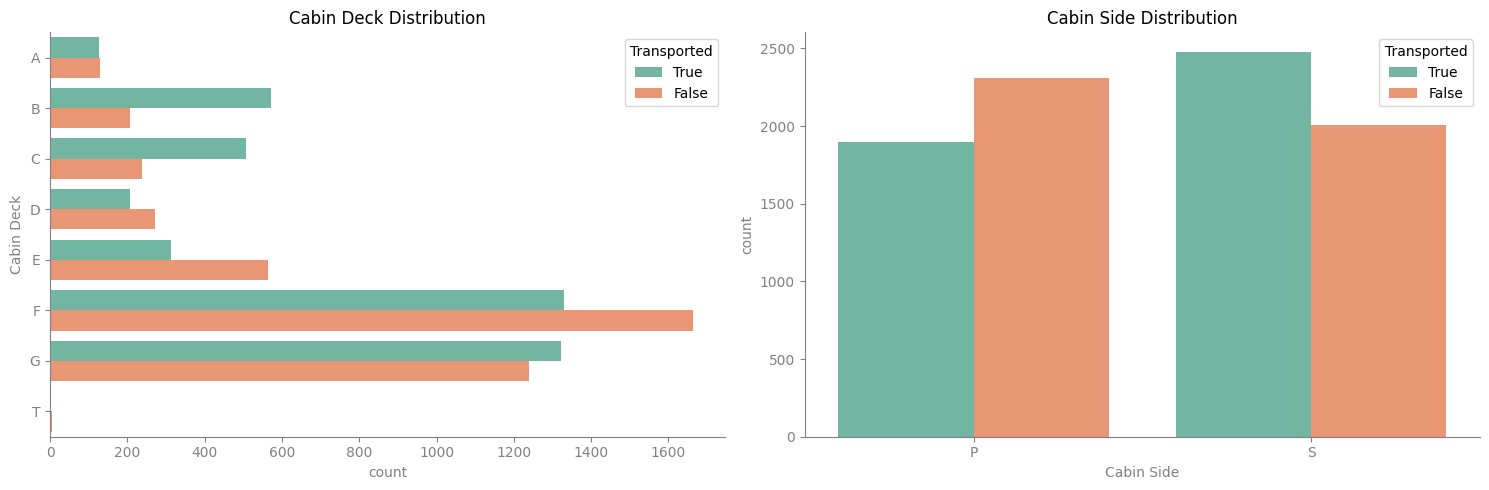

In [108]:
plt.figure(figsize = (15, 5))
ax = plt.subplot(1, 2, 1)
cd_order = ["A", "B", "C", "D", "E", "F", "G", "T"]
sns.countplot(y = "Cabin Deck", data = train_df, hue = "Transported", order = cd_order, palette="Set2", hue_order = order_transported)
plt.title("Cabin Deck Distribution")
plot_style(ax)
plt.tight_layout()
ax = plt.subplot(1,2,2)
sns.countplot(x = "Cabin Side", data = train_df, hue = "Transported", palette = "Set2", hue_order = order_transported)
plt.title("Cabin Side Distribution")
plot_style(ax)
plt.tight_layout()

### ❕ Observations
* From Cabin Deck we can observe that most of the people are from F & G Deck. Passengers from F Deck are comparatively less transported and passengers from G Deck are equally transported.
* There are very few passengers in cabin T
* Passengers from Cabin Deck B & C are very highly transported.
* Passengers from cabin A are equally transported
* Passengers from cabin E are less transported
* From Cabin Side we can observe that almost half passengers were from cabin side S and half from cabin side P. 
* Passenger from S side are highly transported, and from P side are less transported


6. Statical analysis on Cabin Number feature

In [109]:
train_df["Cabin Number"] = train_df["Cabin Number"].astype(int)
test_df["Cabin Number"] = test_df["Cabin Number"].astype(int)

train_df["Cabin Number"].describe()

count    8693.000000
mean      596.398942
std       506.637799
min         0.000000
25%       173.000000
50%       427.000000
75%       983.000000
max      1894.000000
Name: Cabin Number, dtype: float64

7. Visualizing "Cabin Number" feature

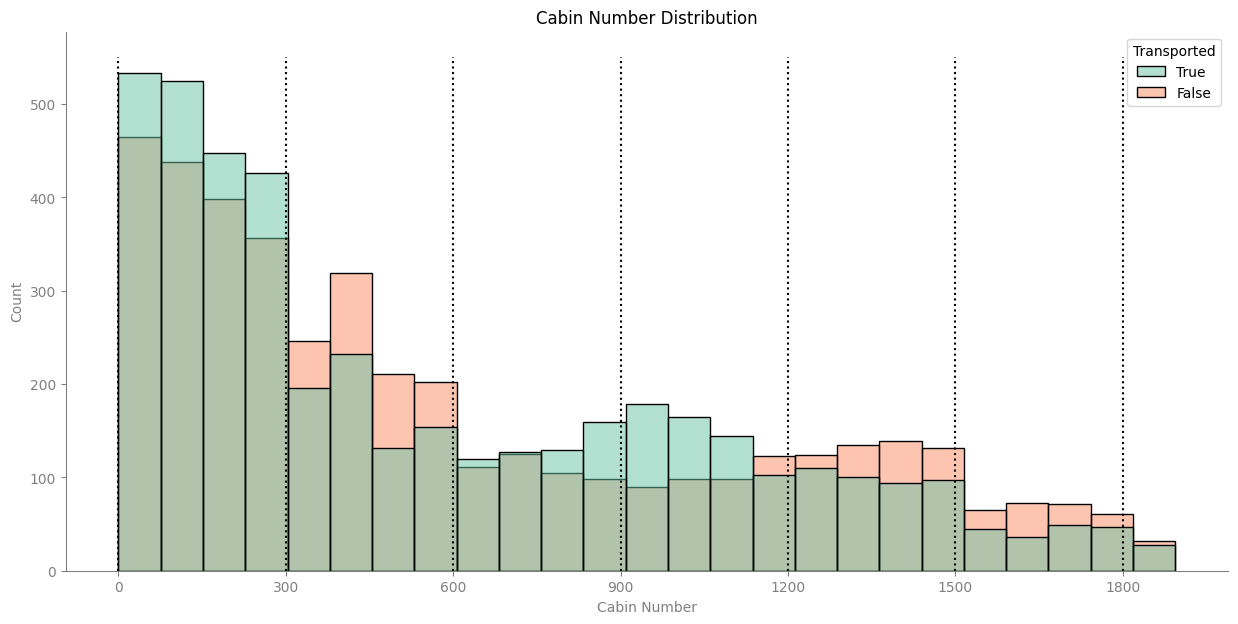

In [110]:
x_ticks = list(range(0, 1900, 300))
ax = plt.figure(figsize = (15,7))
sns.histplot(x = "Cabin Number", data = train_df, hue = "Transported", palette = "Set2", hue_order = order_transported)
plt.xticks(x_ticks)
for i in x_ticks:
        plt.vlines(i, ymin = 0, ymax = 550, color = "black", linestyles = "dotted")
plt.title("Cabin Number Distribution")
plot_style(ax.gca())

### ❕ Observations
We can observe that Cabin Number can be divided into different regions with group of 300 passenegrs. So we can create a new features Cabin Regions which will indicate passenger cabin number region.

8. Creating new feature "Cabin Regions" from "Cabin Number"

In [111]:
def cabin_regions(df):
    df["Cabin Region 1"] = (df["Cabin Number"] < 300)
    df["Cabin Region 2"] = (df["Cabin Number"] >= 300) & (df["Cabin Number"] < 600)
    df["Cabin Region 3"] = (df["Cabin Number"] >= 600) & (df["Cabin Number"] < 900)
    df["Cabin Region 4"] = (df["Cabin Number"] >= 900) & (df["Cabin Number"] < 1200)
    df["Cabin Region 5"] = (df["Cabin Number"] >= 1200) & (df["Cabin Number"] < 1500)
    df["Cabin Region 6"] = (df["Cabin Number"] >= 1500)

In [112]:
cabin_regions(train_df)
cabin_regions(test_df)

In [113]:
# We don't need Cabin Number Feature anymore so we will drop this feature
train_df.drop(columns = ["Cabin Number"],inplace = True)
test_df.drop(columns = ["Cabin Number"],inplace = True)

9. Visualizing Cabin Region feature

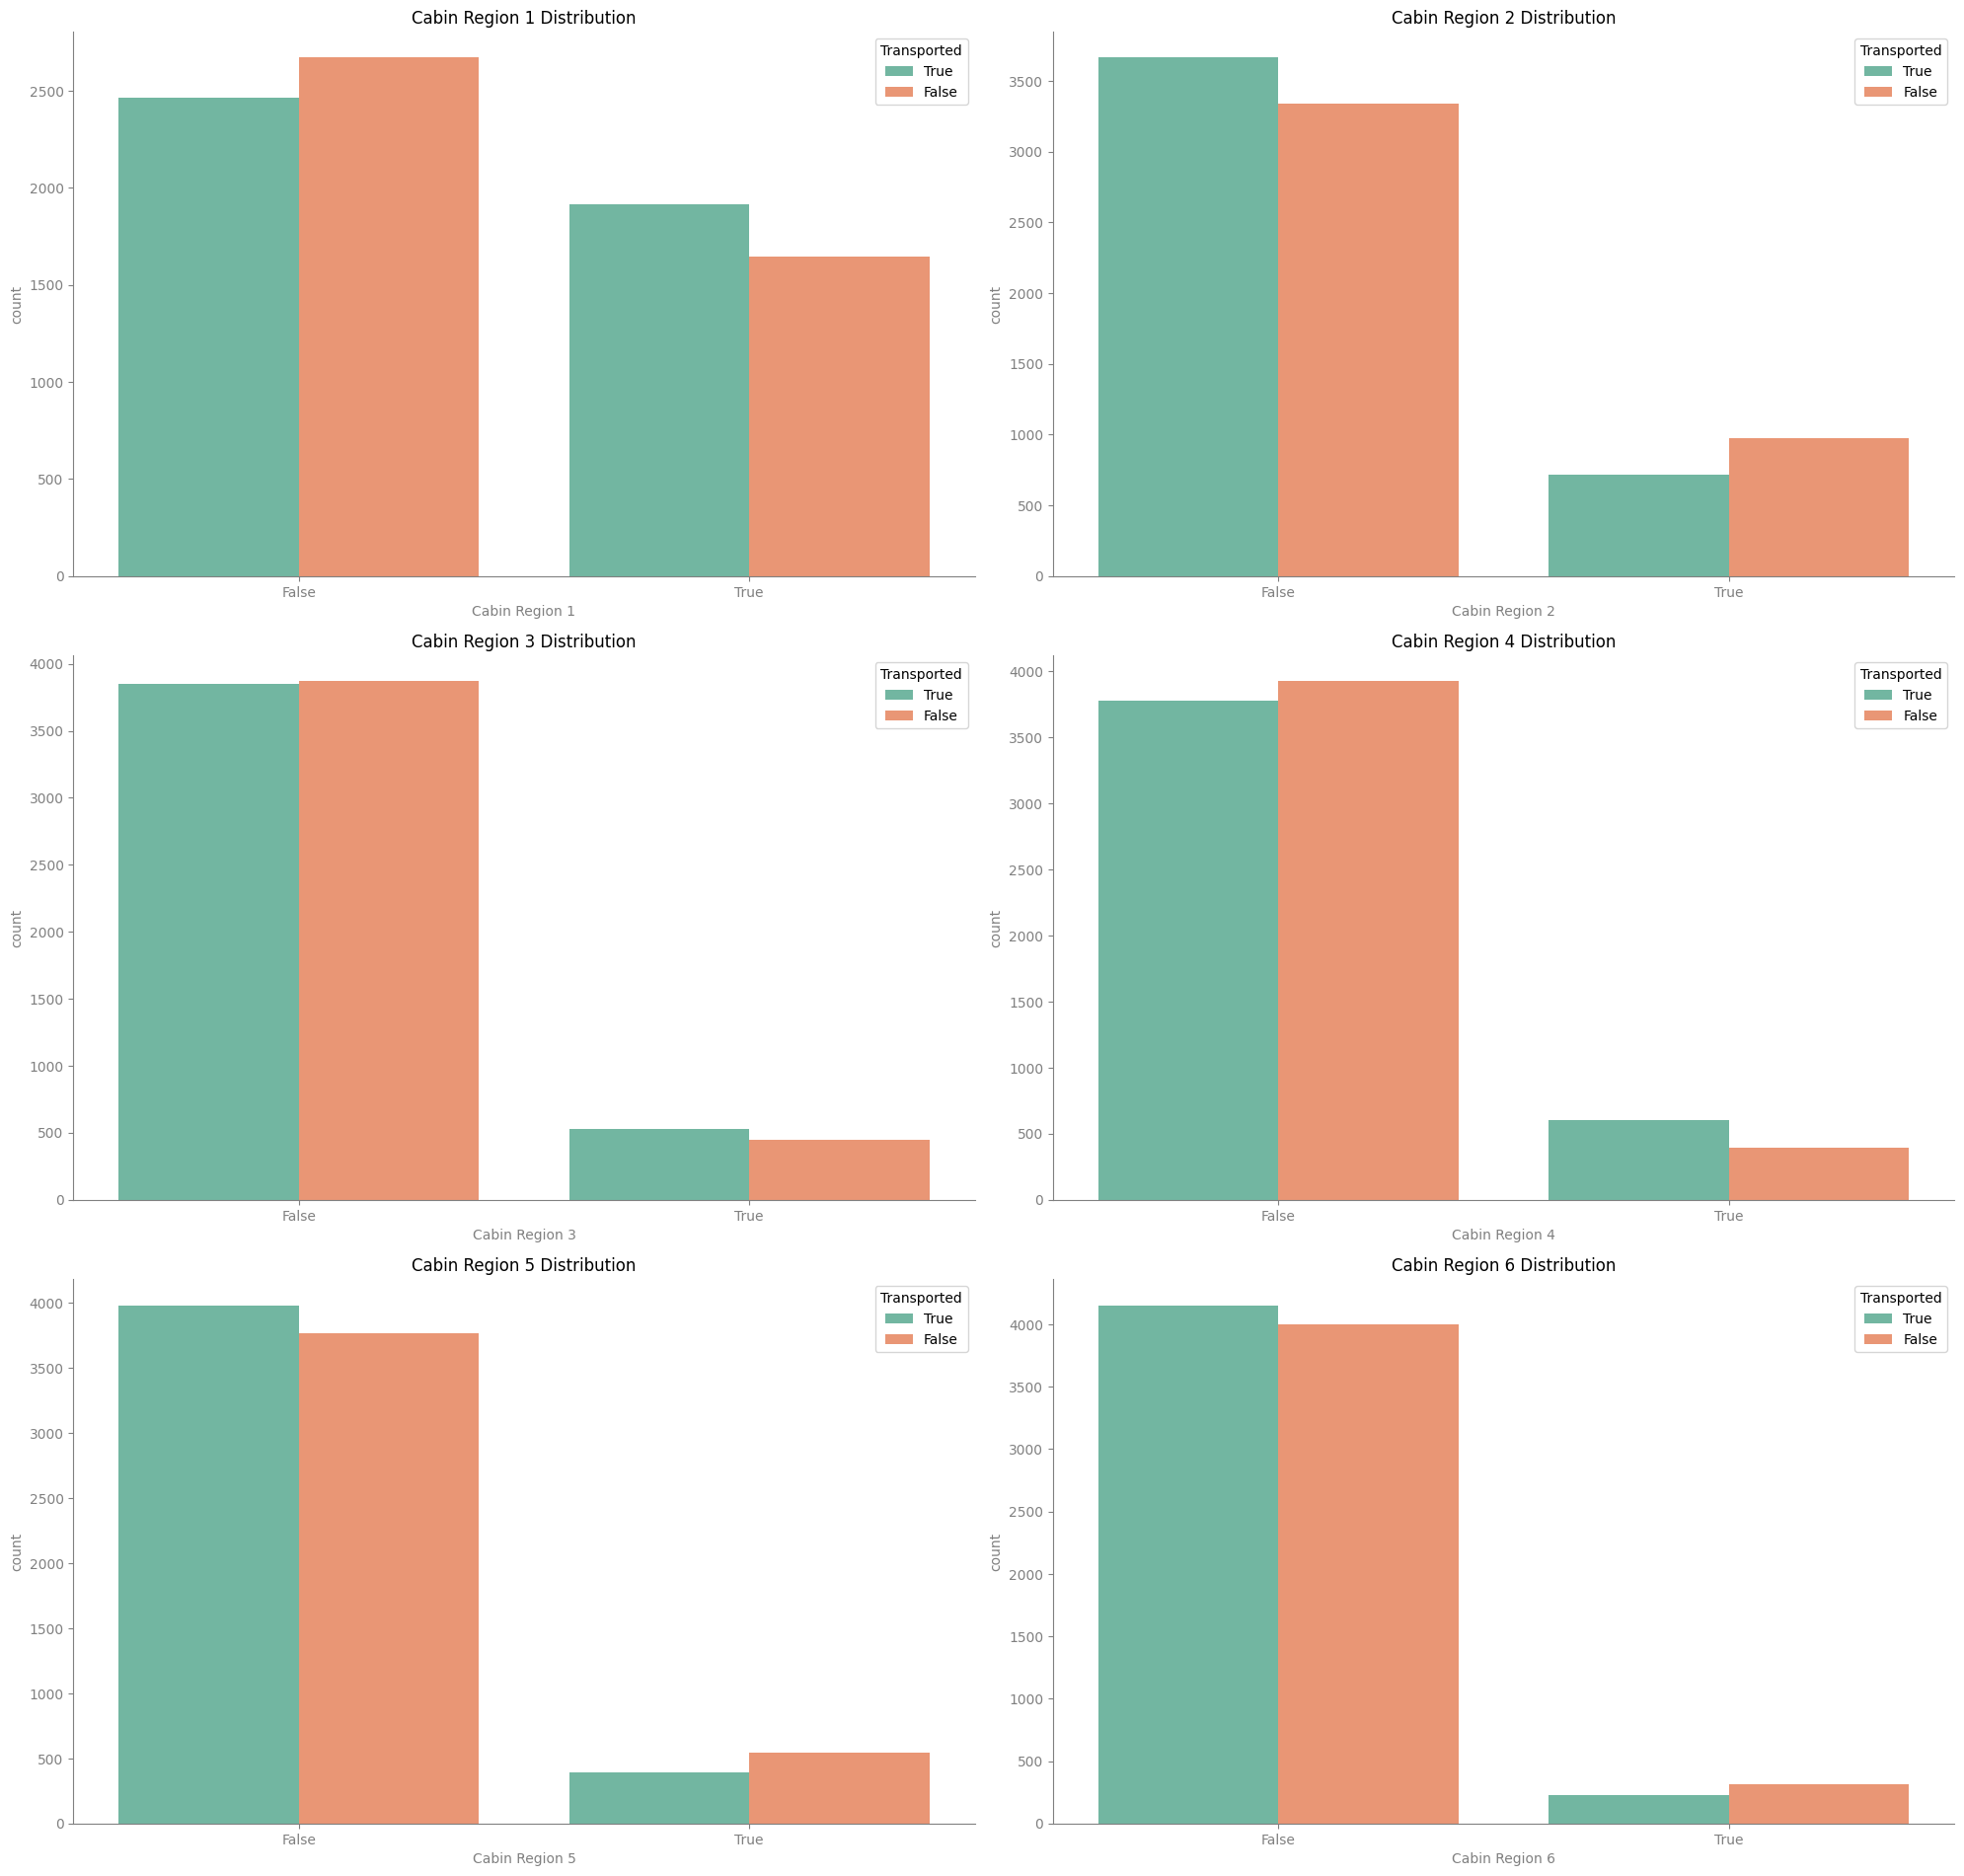

In [114]:
cols = ["Cabin Region 1", "Cabin Region 2", "Cabin Region 3", "Cabin Region 4", "Cabin Region 5", "Cabin Region 6"]
plt.figure(figsize = (20,25))
for i, value in enumerate(cols):
    ax = plt.subplot(4,2,i + 1)
    sns.countplot(x = value, hue = "Transported", data = train_df, palette = "Set2", hue_order = order_transported)
    plt.title(f"{value} Distribution")
    plt.tight_layout()
    plot_style(ax)

### ❕ Observations
We can observe that passengers from Cabin Region 1 are highly transported when compared with other cabin regions

10. Creating new feature from "Age"

In [115]:
train_df["Age"].head().to_frame()

,Age
0,39.0
1,24.0
2,58.0
3,33.0
4,16.0


### ❔ How we will do feature engineering on Age Feature
As we have done EDA on Age feature we collected some insights over there that the ages can be splitted into different groups based on Transported.

11. Creating age groups from "Age"

In [116]:
def age_groups(df):
    age_group = []
    for i in df["Age"]:
        if i <= 18:
            age_group.append("Age 0-18")
        elif i > 18 and i <= 38:
            age_group.append("Age 19-38")
        elif i > 38:
            age_group.append("Age 38+")
        else:
            age_group.append(np.nan)
    df["Age Group"] = age_group

In [117]:
age_groups(train_df)
age_groups(test_df)

12. Visualizing "Age Group" feature

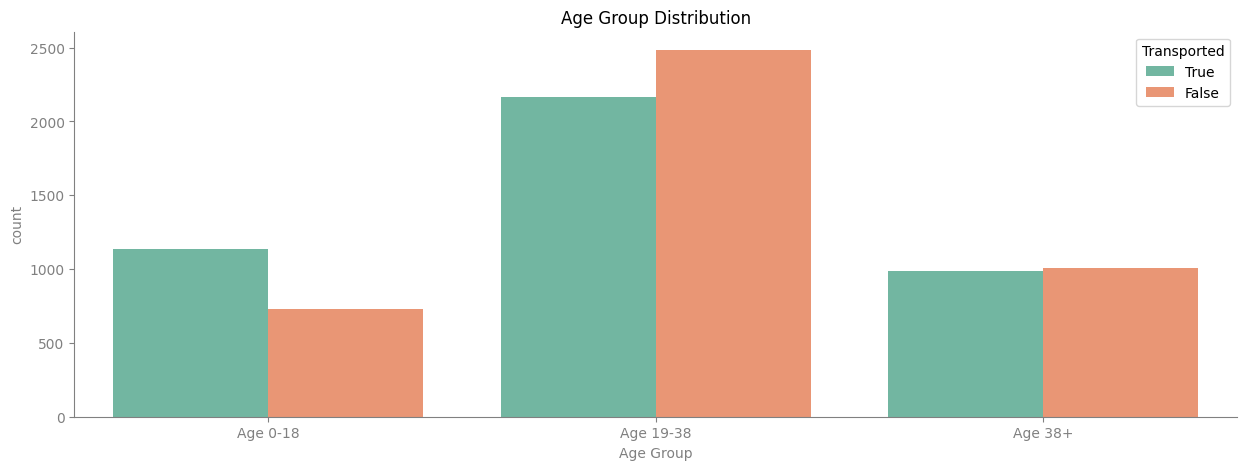

In [118]:
order = sorted(train_df["Age Group"].value_counts().keys().to_list())
ax = plt.figure(figsize = (15, 5))
sns.countplot(x = "Age Group", hue = "Transported", data = train_df, palette = "Set2", hue_order = order_transported, order = order)
plt.title("Age Group Distribution")
plot_style(ax.gca())

### ❕ Observations
* Age 0-18 are more liked to be transported
* Age 19-38 are less likely to be transported
* Age 38+ are equally transported

13. Creating new features using all expenditude features

In [119]:
train_df[["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]].head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0
2,43.0,3576.0,0.0,6715.0,49.0
3,0.0,1283.0,371.0,3329.0,193.0
4,303.0,70.0,151.0,565.0,2.0


### ❔ How can we do feature engineering on all expenditure features
1. We can create a Total Expenditure Feature by combining all the expenditures.
2. We can create a No Spending boolean feature from Total Expenditure feature indicating True for those passengers who have spent 0 expense.
3. We can split Total Expenditure into different categories indicating whether the person is having no_expense, low_expense, medium_expense or high_expense and can create a new feature Expenditure Category.

In [120]:
def new_features(df):
    exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
    df["Total Expenditure"] = df[exp_cols].sum(axis = 1)
    df["No Spending"] = (df["Total Expenditure"] == 0)

In [121]:
new_features(train_df)
new_features(test_df)

14. Visualizing "Total Expenditure" feature

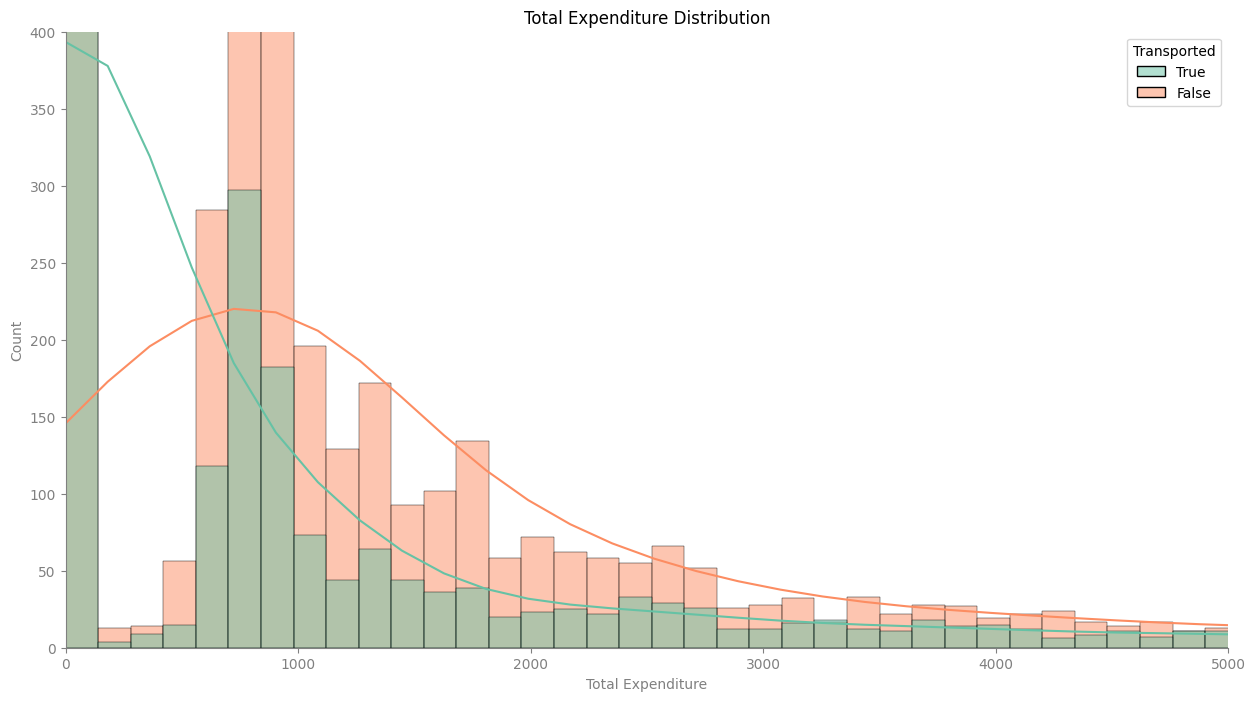

In [122]:
ax = plt.figure(figsize = (15, 8))
sns.histplot(x = "Total Expenditure", hue = "Transported", data = train_df, kde = True, palette = "Set2", hue_order = order_transported)
plt.ylim(0, 400)
plt.xlim(0, 5000)
plt.title("Total Expenditure Distribution")
plot_style(ax.gca())

15. Generating statical information from Total Expenditure feature

In [123]:
train_df["Total Expenditure"].describe()

count     8693.000000
mean      1440.866329
std       2803.045694
min          0.000000
25%          0.000000
50%        716.000000
75%       1441.000000
max      35987.000000
Name: Total Expenditure, dtype: float64

### ❕ Observations
* If Total Expenditure is equal to 0 then No Expense category.
* If Total Expenditure is between 1-716 then Low Expense category.
* If Total Expenditure is between 717-1441 then Medium Expense category.
* If Total Expenditure is greater thean 1441 then High Expense category.

16. Splitting Total Expenditure feature in categories

In [124]:
def split_expenditure(df):
    split_expense = []
    for val in df["Total Expenditure"]:
        if val == 0:
            split_expense.append("No Expense")
        elif (val > 0 and val <= 716):
            split_expense.append("Low Expense")
        elif (val > 716 and val <= 1441):
            split_expense.append("Medium Expense")
        elif (val > 1441):
            split_expense.append("High Expense")
    df["Expenditure Category"] = split_expense

In [125]:
split_expenditure(train_df)
split_expenditure(test_df)

17. Visualizing "No Spending" & "Expenditure Category" features

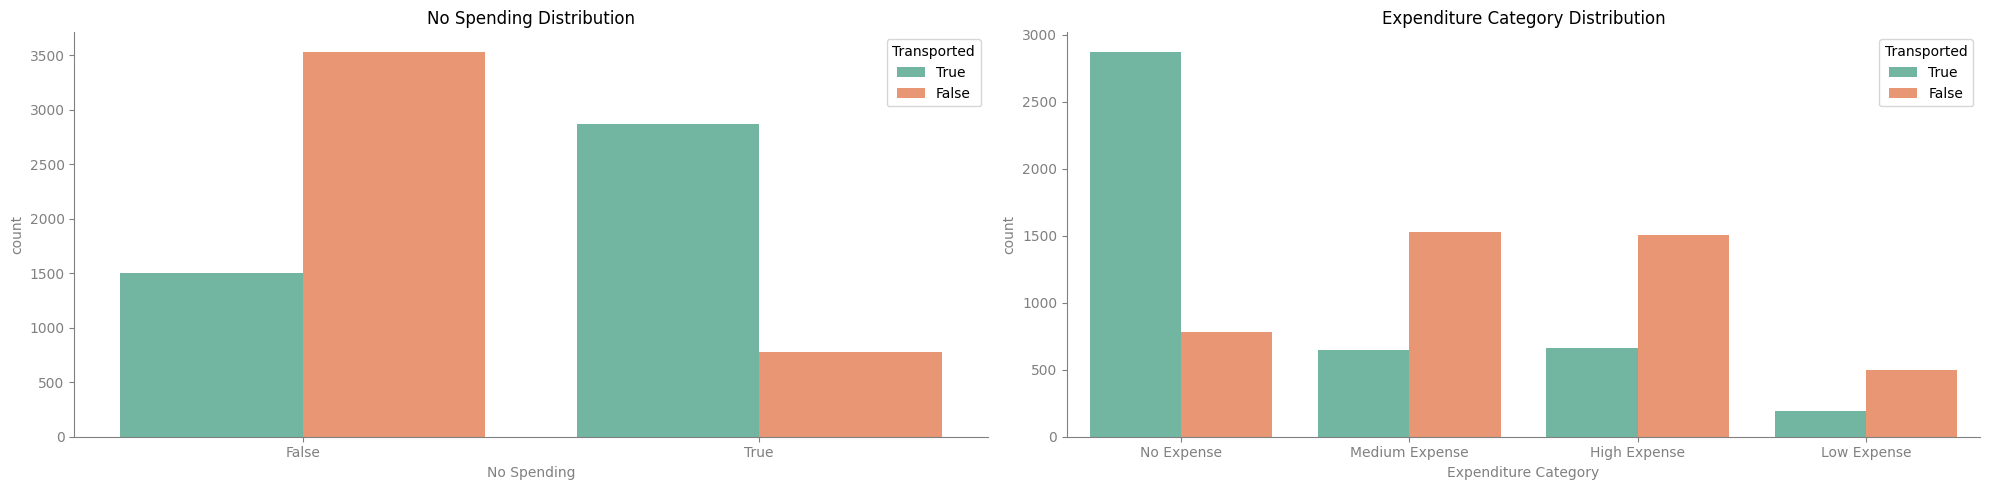

In [126]:
cols = ["No Spending", "Expenditure Category"]
plt.figure(figsize = (20, 5))
for idx, val in enumerate(cols):
    ax = plt.subplot(1, 2, idx + 1)
    sns.countplot(x = val, hue = "Transported", data = train_df, palette = "Set2", hue_order = order_transported)
    plt.title(f"{val} Distribution")
    plot_style(ax)
    plt.tight_layout()